### Import Libraries

In [ ]:
#Pretrained Model EfficientNetB1 without Top Layer
# !wget "https://storage.googleapis.com/keras-applications/efficientnetb1_notop.h5"

In [1]:
import tensorflow as tf
import os
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.optimizers import Adam

----

### Create model

In [2]:
#Use pretrained model as transfer learning layers
local_weight_file = './pretrained/efficientnetb1_notop.h5'

#Adjust input shape and weights
pre_trained_model = EfficientNetB1(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

In [3]:
# Load the downloaded pre-trained weights
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
#Specify input layer model
last_layer = pre_trained_model.get_layer('input_1')
print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  [(None, 150, 150, 3)]


In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add hidden layers
x = layers.Dense(1024, activation='relu')(x)
# Add dropout
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification, sigmoid are used because the model only have 2 ouputs
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
acneModel = Model(pre_trained_model.input, x) 

# Print the model summary
acneModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1024)              69121024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Compiled the model using adam optimizer and binary classification
acneModel.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [8]:
base_dir = '../Dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training acne pictures
train_acne_dir = os.path.join(train_dir, 'acne3') 

# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal2') 

# Directory with validation acne pictures
validation_acne_dir = os.path.join(validation_dir, 'acne2') 

# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal2')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['acne3', 'normal2'],
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         classes=['acne2', 'normal2'],
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 408 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [9]:
#Defining callback for preventing underfitting and overfitting
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and (logs.get('accuracy') > 0.99 or logs.get('accuracy') < 0.5):
            print("\nCancelling training")
            self.model.stop_training = True

In [10]:
#Train the model
callbacks = myCallback()
history = acneModel.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            callbacks=[callbacks])

Epoch 1/25
21/21 [==============================] - 8s 358ms/step - loss: 3.1482 - accuracy: 0.6667 - val_loss: 1.7377 - val_accuracy: 0.6918
Epoch 2/25
21/21 [==============================] - 8s 357ms/step - loss: 0.8449 - accuracy: 0.7132 - val_loss: 1.4314 - val_accuracy: 0.6918
Epoch 3/25
21/21 [==============================] - 8s 366ms/step - loss: 0.6571 - accuracy: 0.7181 - val_loss: 0.6583 - val_accuracy: 0.6855
Epoch 4/25
21/21 [==============================] - 7s 347ms/step - loss: 0.6300 - accuracy: 0.7206 - val_loss: 0.7397 - val_accuracy: 0.6918
Epoch 5/25
21/21 [==============================] - 7s 342ms/step - loss: 0.5282 - accuracy: 0.7745 - val_loss: 0.6181 - val_accuracy: 0.6541
Epoch 6/25
21/21 [==============================] - 7s 343ms/step - loss: 0.6187 - accuracy: 0.7475 - val_loss: 0.6470 - val_accuracy: 0.6101
Epoch 7/25
21/21 [==============================] - 7s 344ms/step - loss: 0.5451 - accuracy: 0.7647 - val_loss: 0.6223 - val_accuracy: 0.6855
Epoch 

----

### Visualizing Accuracy Plot

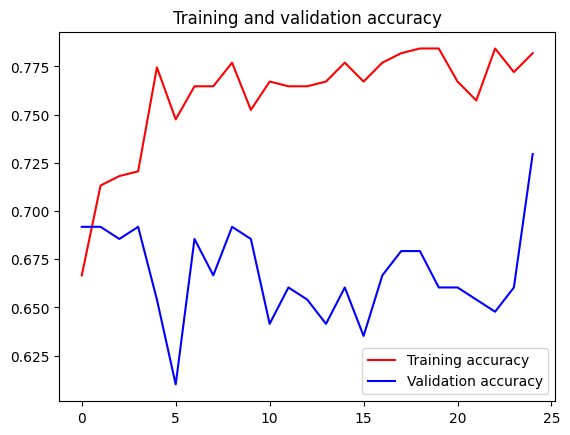

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

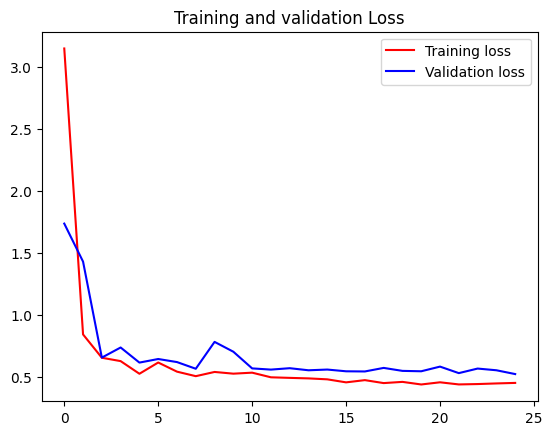

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

----

### Try Input Image

In [144]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
# from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

root = tk.Tk()
root.withdraw()
uploaded = filedialog.askopenfilename()
 
  # predicting images
path = uploaded
img = load_img(path, target_size=(224, 224))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = acneModel.predict(images, batch_size=10)

if classes[0]>0.5:
  print("no dullness/acne")
  print()
else:
  print("dullness/acne")
  print()
 

1/1 [==============================] - 0s 57ms/step
no acne [45.994083] %



----

### Convert and Save Model

In [ ]:
import pickle

dump = {
    'model':acneModel,
}
# Save your model to a file using pickle
with open("scanningmodel.pkl", "wb") as f:
    pickle.dump(dump, f)